# Import modules

In [13]:
from sklearn.datasets import load_diabetes
import pickle
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import os
import torch


from synthcity.metrics.eval_performance import (
    PerformanceEvaluatorMLP,
    PerformanceEvaluatorXGB,
)
from synthcity.utils import reproducibility
from synthcity.plugins import Plugins
import synthcity.logger as log
from synthcity.plugins.core.dataloader import GenericDataLoader


reproducibility.clear_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Plugins(categories=["generic"]).list()

assert device.type == 'cuda'


# Reload

In [14]:
import importlib
import DGE_experiments
import DGE_data
import DGE_utils
importlib.reload(DGE_experiments)
importlib.reload(DGE_data)
importlib.reload(DGE_utils)


<module 'DGE_utils' from '/home/bv292/synthcity/DGE_utils.py'>

# Load data and settings

In [20]:
from DGE_data import get_real_and_synthetic

datasets = ['moons', 'cal_housing', 'seer', 'cutract', 'diabetes', 'breast_cancer', 'wine', 'iris', 'covtype']
model_name = 'ctgan'  # synthetic data model
    
nsyn = None  # number of synthetic data points per synthetic dataset. Defaults to same as generative training size if None
p_train = None  # proportion of training data for generative model. Default values if None
n_models = 20  # number of models in ensemble

load = True  # results
load_syn = True  # data
save = True  # save results and data

verbose = False

for dataset in datasets:

    workspace_folder = os.path.join("workspace", dataset,model_name)
    results_folder = os.path.join("uncertainty_results",dataset,model_name)

    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                        p_train=p_train,
                                        n_models=n_models,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose)


    nsyn = len(X_syns[0])
    print('Shape of each synthetic dataset:', X_syns[0].shape)


n_total 10000 n_train: 1000
Shape of each synthetic dataset: (1000, 3)
n_total 20640 n_train: 2064
Shape of each synthetic dataset: (2064, 9)
n_total 20000 n_train: 2000
Shape of each synthetic dataset: (2000, 7)
n_total 20000 n_train: 2000


100%|██████████| 2000/2000 [02:10<00:00, 15.33it/s]


Shape of each synthetic dataset: (2000, 7)
n_total 442 n_train: 265
Shape of each synthetic dataset: (265, 11)
n_total 569 n_train: 341


100%|██████████| 2000/2000 [00:47<00:00, 41.87it/s]


Shape of each synthetic dataset: (341, 31)


# Analyses

## Model Training

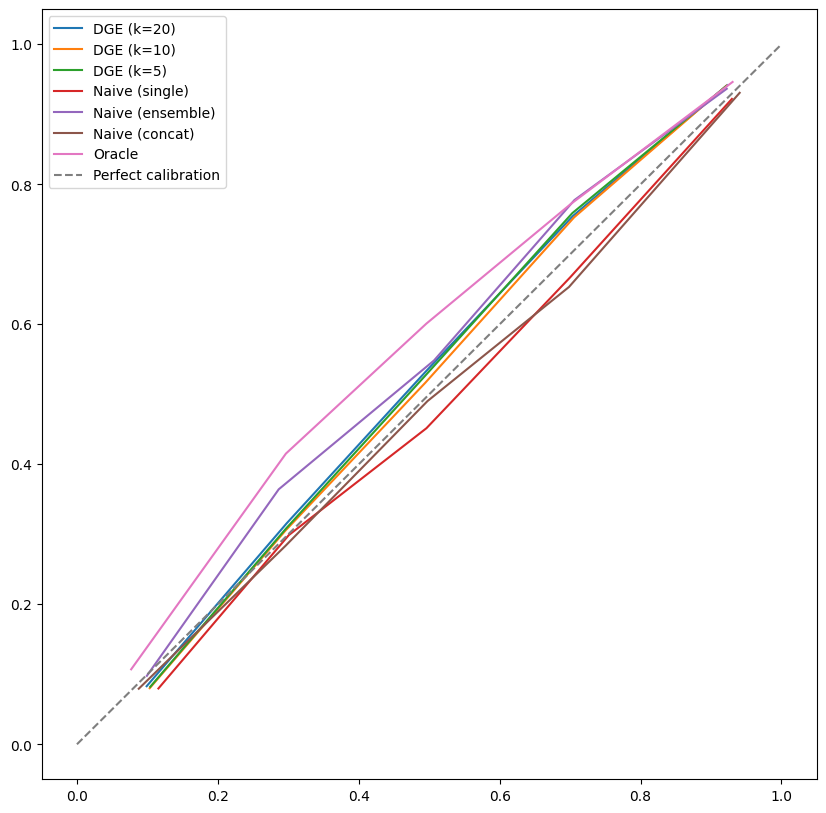

\begin{tabular}{lrrrrrrr}
\toprule
{} &    AUC &    Acc &     F1 &  Precision &  Recall &    NLL &  Brier \\
\midrule
DGE (k=20)       &  0.905 &  0.827 &  0.820 &      0.854 &   0.789 &  0.392 &  0.123 \\
DGE (k=10)       &  0.905 &  0.826 &  0.820 &      0.849 &   0.792 &  0.392 &  0.122 \\
DGE (k=5)        &  0.905 &  0.826 &  0.819 &      0.852 &   0.788 &  0.393 &  0.123 \\
Naive (single)   &  0.894 &  0.813 &  0.812 &      0.817 &   0.807 &  0.414 &  0.130 \\
Naive (ensemble) &  0.894 &  0.818 &  0.808 &      0.854 &   0.767 &  0.416 &  0.131 \\
Naive (concat)   &  0.911 &  0.832 &  0.833 &      0.831 &   0.834 &  0.379 &  0.118 \\
Oracle           &  0.908 &  0.824 &  0.809 &      0.888 &   0.742 &  0.396 &  0.124 \\
\bottomrule
\end{tabular}



In [16]:
from DGE_experiments import predictive_experiment

all_scores = []
dataset_type = 'classification'

for dataset in datasets:

    workspace_folder = os.path.join("workspace", dataset,model_name)
    results_folder = os.path.join("uncertainty_results",dataset,model_name)

    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                        p_train=p_train,
                                        n_models=n_models,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose)
    if X_gt.targettype != dataset_type:
        continue

    y_preds, scores = predictive_experiment(X_gt,
                      X_syns,
                      workspace_folder=workspace_folder,
                      results_folder=results_folder,
                      save=save,
                      load=load)


    print(f'Dataset {dataset}\n', scores.to_latex())
    all_scores.append(scores)

print('All scores:')
all_scores = pd.concat(all_scores)
df_mean = all_scores.groupby(level=0).mean()
print(df_mean.to_latex())

# Model Evaluation

We compare the single baseline model vs the generative uncertainty model vs an oracle. Workflow.
0. Train and generate synthetic datasets $S_i$.
1. Take each synthetic dataset $S_i$ and split it up in train and test.
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic dataset's test set $S_{i,test}$, giving $\hat{M}^S_i$ [Single performance]
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $M_i$ [Oracle performance]
5. Evaluate on the other synthetic datasets $\cup_{j\neq i} S_{j}$, giving $\hat{M}^G_i$ [Generative performance]
6. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average over all models $f_i$. 
7. Repeat 1-6 for different model classes $f$

N.B. the idea of the above, is that the trained model $f_i$ is the same for each evaluation type. In the model selection section, we will compare the performance of different model classes, where we will train a new model for each evaluation type (hence the aim is to evaluate which class is best, while the model itself may vary).

In [17]:
from DGE_experiments import model_evaluation_experiment

if X_gt.targettype is not None:
    print('Aggregate approaches:')
    res = model_evaluation_experiment(X_gt, X_syns, workspace_folder=workspace_folder, model_type='mlp')[0]
    print(res)


Aggregate approaches:
                AUC           Acc            F1     Precision        Recall  \
oracle  90.24 ± 0.4  82.11 ± 0.87  81.91 ± 1.75   82.91 ± 3.3  81.39 ± 5.53   
naive   90.14 ± 2.1    82.1 ± 2.2  80.16 ± 3.21  80.55 ± 5.75  80.62 ± 7.66   
dge     89.1 ± 0.53   81.3 ± 0.89  79.33 ± 1.72  79.89 ± 3.08  79.22 ± 5.31   

                 NLL         Brier  
oracle   40.6 ± 2.44  12.67 ± 0.77  
naive   41.38 ± 3.63  12.94 ± 1.32  
dge     42.54 ± 2.42  13.36 ± 0.74  


# Model Selection
Essentially repeat the above for different models

In [19]:
from DGE_experiments import model_selection_experiment

if X_gt.targettype is not None:
    if X_gt.targettype == 'classification':
        metric = 'Acc'
    elif X_gt.targettype == 'regression':
        metric = 'MAE'
    
    results, means_sorted = model_selection_experiment(X_gt, X_syns, relative=False, metric=metric, workspace_folder=workspace_folder, load=load, save=save)


print(results.to_latex())

AttributeError: predict_proba is not available when  probability=False

## Influence of synthetic data size

Let's study the effect of synthetic data size.

In [ ]:
from DGE_experiments import predictive_varying_nsyn

predictive_varying_nsyn(X_gt, X_syns, dataset, model_name, n_models,
                        nsyn, results_folder, workspace_folder, load, save, verbose=True)


## Density estimation


In [ ]:
from DGE_experiments import density_experiment

if X_gt.targettype is None:
    density_experiment(X_gt, X_syns, load, save)


# Model parameter estimation
Using a linear model

# Cross validation

We compare the single baseline model vs the generative uncertainty model. Single workflow
1. Take each synthetic dataset $S_i$ and split it up in train and test.
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic datasets test set $S_{i,test}$
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $\hat{M}_i$
5. Average results across the different synthetic datasets, giving $M_i$.
6. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average.

Versus our baseline
1. Take each synthetic dataset $S_i$ and split it up in train and test
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic datasets test set $S_{i,test}
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $\hat{M}_i$
5. Average results across the different synthetic datasets, giving $M_i$.
6. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average.


Cross-validation approach to test which type of model would perform best on real data. We compare the single baseline model vs the generative uncertainty model vs an oracle. Workflow Cross-validation.
0. Train and generate synthetic datasets $S_i$.
1. Use CV to train and evaluate models $f_i$ on each $S_i$. Repeat for all $S_i$. [Single performance]
2. Use CV \textit{over datasets $S_i$} (i.e. train on all but one $S_i$, evaluate on remaining and repeat) to train and evaluate models $f_i$.
3. For both cases, evaluate the model also on the true real test set (oracle), $D_{test}$, giving $M_i$ [Oracle performance]
4. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average over all models $f_i$. 